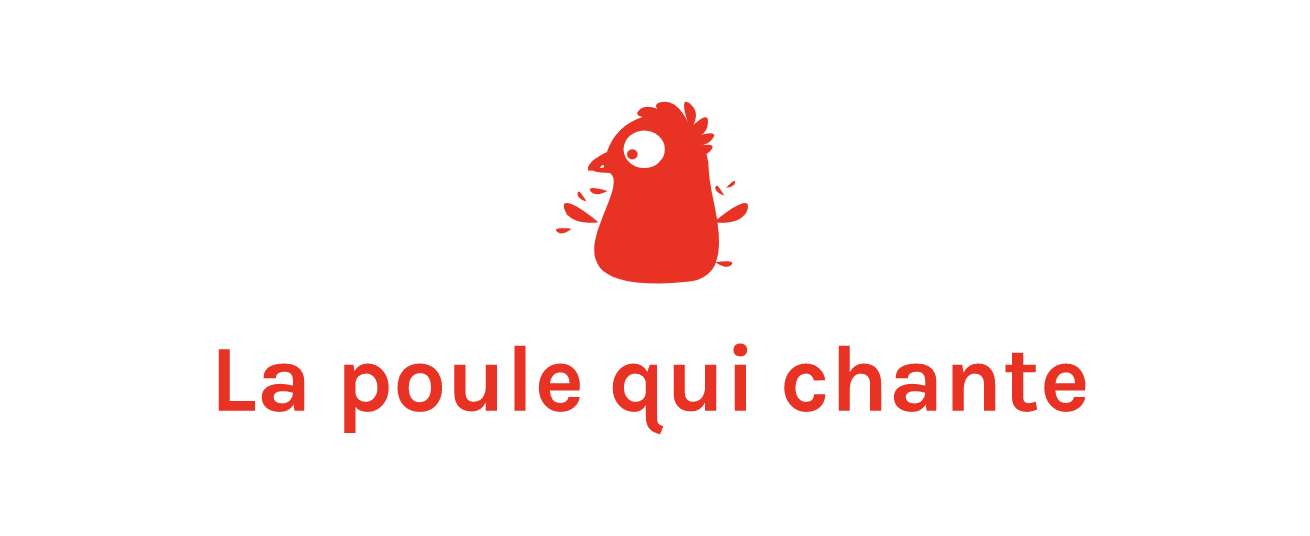

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing, cluster, metrics, decomposition
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as sch
%matplotlib inline
import warnings

# Scénario
Vous travaillez chez La poule qui chante, une entreprise française d’agroalimentaire. Elle souhaite se développer à l'international.

# Mission
Pars des données de la FAO (Food and Agriculture Organization) que je te mets en pièce jointe pour faire ton analyse. Si tu veux aller plus loin, notamment avec les critères de l’analyse PESTEL, tu peux récupérer et utiliser toutes les données en open data que tu souhaites sur le site de la FAO.

Pour la partie analyse, dans un premier temps j’aimerais que tu testes la classification ascendante hiérarchique, avec un dendrogramme comme visualisation. Ensuite tu pourras utiliser la méthode des k-means, afin d’affiner l’analyse et comparer les résultats des deux méthodes de clustering. N'hésite pas à prendre le temps d’analyser les centroïdes de tes classes. Tu peux également réaliser une ACP afin de visualiser les résultats de ton analyse, comprendre les groupes, les liens entre les variables, les liens entre les individus...

# Sommaire

# Partie 1 : Données
## Disponibilité alimentaire 2017 (tous les aliments)

In [2]:
df_disponibilite_alimentaire_2017 = pd.read_csv(
    "DisponibiliteAlimentaire_2017.csv")
df_population_2000_2018 = pd.read_csv("Population_2000_2018.csv")
Autres_indicateurs = pd.read_csv("Autres_indicateurs.csv")

In [3]:
df_disponibilite_alimentaire_2017.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [4]:
df_disponibilite_alimentaire_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Code Domaine            176600 non-null  object 
 1   Domaine                 176600 non-null  object 
 2   Code zone               176600 non-null  int64  
 3   Zone                    176600 non-null  object 
 4   Code Élément            176600 non-null  int64  
 5   Élément                 176600 non-null  object 
 6   Code Produit            176600 non-null  int64  
 7   Produit                 176600 non-null  object 
 8   Code année              176600 non-null  int64  
 9   Année                   176600 non-null  int64  
 10  Unité                   176600 non-null  object 
 11  Valeur                  176600 non-null  float64
 12  Symbole                 176600 non-null  object 
 13  Description du Symbole  176600 non-null  object 
dtypes: float64(1), int64

In [5]:
df_disponibilite_alimentaire_2017.nunique()

Code Domaine                 1
Domaine                      1
Code zone                  174
Zone                       174
Code Élément                17
Élément                     17
Code Produit                98
Produit                     98
Code année                   1
Année                        1
Unité                        4
Valeur                    7250
Symbole                      2
Description du Symbole       2
dtype: int64

In [6]:
#pivot table
df_disponibilite_alimentaire_tous_aliments_2017 = pd.pivot_table(
    df_disponibilite_alimentaire_2017, values='Valeur', index="Zone", columns='Élément',aggfunc='sum')

In [7]:
# supression des colonnes
df_disponibilite_alimentaire_tous_aliments_2017 = df_disponibilite_alimentaire_tous_aliments_2017.drop(
    ['Alimentation pour touristes', 'Aliments pour animaux','Disponibilité intérieure',
       'Autres utilisations (non alimentaire)','Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)', 'Pertes',
       'Résidus', 'Semences', 'Traitement', 'Variation de stock'], axis=1)

In [8]:
#reset index
df_disponibilite_alimentaire_tous_aliments_2017=df_disponibilite_alimentaire_tous_aliments_2017.reset_index()

In [9]:
df_disponibilite_alimentaire_tous_aliments_2017.head()

Élément,Zone,Exportations - Quantité,Importations - Quantité,Nourriture,Production
0,Afghanistan,601.0,4555.0,12968.0,11609.0
1,Afrique du Sud,10968.0,9020.0,31726.0,68455.0
2,Albanie,156.0,884.0,3631.0,4231.0
3,Algérie,743.0,19718.0,33056.0,26763.0
4,Allemagne,58793.0,66550.0,77988.0,167828.0


## Disponibilité alimentaire 2017 (toutes les viandes)

In [10]:
# visualisation des produits uniques
df_disponibilite_alimentaire_2017.Produit.unique()

array(['Blé et produits', 'Riz et produits', 'Orge et produits',
       'Maïs et produits', 'Seigle et produits', 'Avoine',
       'Millet et produits', 'Sorgho et produits', 'Céréales, Autres',
       'Pommes de Terre et produits', 'Ignames', 'Racines nda',
       'Sucre, canne', 'Sucre, betterave', 'Sucre Eq Brut',
       'Edulcorants Autres', 'Miel', 'Haricots', 'Pois',
       'Légumineuses Autres et produits', 'Noix et produits', 'Soja',
       'Arachides Decortiquees', 'Graines de tournesol',
       'Graines Colza/Moutarde', 'Graines de coton', 'Coco (Incl Coprah)',
       'Sésame', 'Olives', 'Plantes Oleiferes, Autre', 'Huile de Soja',
       "Huile d'Arachide", 'Huile de Tournesol',
       'Huile de Colza&Moutarde', 'Huile Graines de Coton',
       'Huile de Palmistes', 'Huile de Palme', 'Huile de Coco',
       'Huile de Sésame', "Huile d'Olive", 'Huile de Son de Riz',
       'Huile de Germe de Maïs', 'Huil Plantes Oleif Autr',
       'Tomates et produits', 'Oignons', 'Légumes, 

In [11]:
# Création d'une liste avec uniquement les viandes
viandes = ['Viande de Bovins', "Viande d'Ovins/Caprins", 'Viande de Suides',
           'Viande de Volailles', 'Viande, Autre', 'Viande de Anim Aquatiq']

In [12]:
# methode isin()
df_disponibilite_alimentaire_viandes_2017 = df_disponibilite_alimentaire_2017[
    df_disponibilite_alimentaire_2017['Produit'].isin(viandes)]

In [13]:
#pivot table
df_disponibilite_alimentaire_viandes_2017 = pd.pivot_table(
    df_disponibilite_alimentaire_viandes_2017, values='Valeur', index="Zone", columns='Élément',aggfunc='sum')

In [14]:
#colonnes du dataframe
df_disponibilite_alimentaire_viandes_2017.columns

Index(['Alimentation pour touristes', 'Aliments pour animaux',
       'Autres utilisations (non alimentaire)',
       'Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité intérieure', 'Exportations - Quantité',
       'Importations - Quantité', 'Nourriture', 'Pertes', 'Production',
       'Résidus', 'Semences', 'Traitement', 'Variation de stock'],
      dtype='object', name='Élément')

In [15]:
# supression des colonnes
df_disponibilite_alimentaire_viandes_2017 = df_disponibilite_alimentaire_viandes_2017.drop(
    ['Alimentation pour touristes', 'Aliments pour animaux','Disponibilité intérieure',
       'Autres utilisations (non alimentaire)','Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)', 'Pertes',
       'Résidus', 'Semences', 'Traitement', 'Variation de stock'], axis=1)

In [16]:
# rename colonnes
df_disponibilite_alimentaire_viandes_2017 = df_disponibilite_alimentaire_viandes_2017 .rename(
    columns={'Exportations - Quantité': "Export viandes", 'Importations - Quantité': "Import viandes",
             'Nourriture': "Conso Viandes", 'Production':'Production viandes'})

In [17]:
#reset index
df_disponibilite_alimentaire_viandes_2017=df_disponibilite_alimentaire_viandes_2017.reset_index()

In [18]:
df_disponibilite_alimentaire_viandes_2017.head()

Élément,Zone,Export viandes,Import viandes,Conso Viandes,Production viandes
0,Afghanistan,NaN,35.0,312.0,294.0
1,Afrique du Sud,148.0,571.0,3422.0,3130.0
2,Albanie,0.0,51.0,136.0,90.0
3,Algérie,0.0,52.0,748.0,730.0
4,Allemagne,3627.0,2671.0,7255.0,8299.0


## Disponibilité alimentaire 2017 (uniquement Viande de Volailles)

In [19]:
#filtre dispo alimentaire uniquement Viande de Volailles
df_disponibilite_alimentaire_viandes_volailles_2017 = df_disponibilite_alimentaire_2017[
    df_disponibilite_alimentaire_2017['Produit']=='Viande de Volailles']

In [20]:
#pivot table
df_disponibilite_alimentaire_viandes_volailles_2017 = pd.pivot_table(
    df_disponibilite_alimentaire_viandes_volailles_2017, values='Valeur', index="Zone", columns='Élément',aggfunc='sum')

In [21]:
# supression des colonnes
df_disponibilite_alimentaire_viandes_volailles_2017 = df_disponibilite_alimentaire_viandes_volailles_2017.drop(
    ['Alimentation pour touristes', 'Aliments pour animaux','Disponibilité intérieure',
       'Autres utilisations (non alimentaire)','Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)', 'Pertes',
       'Résidus', 'Semences', 'Traitement', 'Variation de stock'], axis=1)

In [22]:
# rename colonnes
df_disponibilite_alimentaire_viandes_volailles_2017 = df_disponibilite_alimentaire_viandes_volailles_2017 .rename(
    columns={'Exportations - Quantité': "Export viandes Volailles", 'Importations - Quantité': "Import viandes Volailles",
             'Nourriture': "Conso Viandes Volailles", 'Production':'Production viandes Volailles'})

In [23]:
#reset index
df_disponibilite_alimentaire_viandes_volailles_2017=df_disponibilite_alimentaire_viandes_volailles_2017.reset_index()

In [24]:
df_disponibilite_alimentaire_viandes_volailles_2017.head()

Élément,Zone,Export viandes Volailles,Import viandes Volailles,Conso Viandes Volailles,Production viandes Volailles
0,Afghanistan,NaN,29.0,55.0,28.0
1,Afrique du Sud,63.0,514.0,2035.0,1667.0
2,Albanie,0.0,38.0,47.0,13.0
3,Algérie,0.0,2.0,264.0,275.0
4,Allemagne,646.0,842.0,1609.0,1514.0


## Population 2000 à 2018 (Social)

In [25]:
df_population_2000_2018.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [26]:
df_population_2000_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

In [27]:
df_population_2000_2018.nunique()

Code Domaine                 1
Domaine                      1
Code zone                  238
Zone                       238
Code Élément                 1
Élément                      1
Code Produit                 1
Produit                      1
Code année                  19
Année                       19
Unité                        1
Valeur                    4398
Symbole                      2
Description du Symbole       2
Note                         1
dtype: int64

In [28]:
# mise valeur avec l'unité correpondante
df_population_2000_2018['Valeur'] = df_population_2000_2018.apply(
    lambda x: x['Valeur']*1000, axis=1)

In [29]:
#pivot table
df_population_2000_2018 = pd.pivot_table(
    df_population_2000_2018, values='Valeur', index='Zone', columns='Année')

In [30]:
# Conserve les années 2000 et 2017 
df_population_2017 = df_population_2000_2018[[2000,2017]]

In [31]:
# création feature Evolution population 2000 à 2017
df_population_2017['Evolution population 2000 à 2017 (%)'] = df_population_2000_2018.apply(
    lambda x: round((x[2017]-x[2000])/x[2000]*100,2), axis=1)

<ipython-input-31-501bfbac6aac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_population_2017['Evolution population 2000 à 2017 (%)'] = df_population_2000_2018.apply(


In [32]:
# drop année 2000
df_population_2017= df_population_2017.drop([2000], axis=1)

In [33]:
#reset_index
df_population_2017 = df_population_2017.reset_index()

In [34]:
#rename colonnes
df_population_2017 = df_population_2017.rename(
    columns={2017: "Population 2017"})

In [35]:
df_population_2017

Année,Zone,Population 2017,Evolution population 2000 à 2017 (%)
0,Afghanistan,36296113.0,74.67
1,Afrique du Sud,57009756.0,26.78
2,Albanie,2884169.0,-7.83
3,Algérie,41389189.0,33.33
4,Allemagne,82658409.0,1.54
...,...,...,...
233,Îles Salomon,636039.0,54.13
234,Îles Turques-et-Caïques,37115.0,84.07
235,Îles Vierges américaines,104751.0,-3.65
236,Îles Vierges britanniques,29577.0,45.62


## Stabilité politique (Politique)

In [36]:
Autres_indicateurs.head()

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Note
0,FS,Données de la sécurité alimentaire,2,Afghanistan,6121,Valeur,21010,Suffisance des apports énergétiques alimentair...,20162018,2016-2018,%,106,NaN
1,FS,Données de la sécurité alimentaire,2,Afghanistan,6128,Valeur,22000,Disponibilité alimentaire par habitant utilisé...,20162018,2016-2018,Kcal/personne/jour,2266,NaN
2,FS,Données de la sécurité alimentaire,2,Afghanistan,6121,Valeur,21012,"Part des céréales, des racines et des tubercul...",20162018,2016-2018,%,74,NaN
3,FS,Données de la sécurité alimentaire,2,Afghanistan,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,55.7,NaN
4,FS,Données de la sécurité alimentaire,2,Afghanistan,6123,Valeur,21014,Disponibilités protéines moyennes d’origine an...,20162018,2016-2018,g/personne/jour,10.7,NaN


In [37]:
Autres_indicateurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6085 entries, 0 to 6084
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code Domaine     6085 non-null   object 
 1   Domaine          6085 non-null   object 
 2   Code zone (FAO)  6085 non-null   int64  
 3   Zone             6085 non-null   object 
 4   Code Élément     6085 non-null   int64  
 5   Élément          6085 non-null   object 
 6   Code Produit     6085 non-null   int64  
 7   Produit          6085 non-null   object 
 8   Code année       6085 non-null   int64  
 9   Année            6085 non-null   object 
 10  Unité            6085 non-null   object 
 11  Valeur           5513 non-null   object 
 12  Note             0 non-null      float64
dtypes: float64(1), int64(4), object(8)
memory usage: 618.1+ KB


In [38]:
Autres_indicateurs.nunique()

Code Domaine          1
Domaine               1
Code zone (FAO)     204
Zone                204
Code Élément          9
Élément               1
Code Produit         37
Produit              37
Code année            2
Année                 2
Unité                 9
Valeur             1877
Note                  0
dtype: int64

In [39]:
Autres_indicateurs.Produit.unique()

array(['Suffisance des apports énergétiques alimentaires moyens (%) (moyenne sur 3 ans)',
       "Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans)",
       'Part des céréales, des racines et des tubercules dans les apports énergétiques alimentaires (%) (moyenne sur 3 ans)',
       'Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)',
       'Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans)',
       'PIB par habitant, ($ PPA internationaux constants de 2011)',
       'Prévalence de la sous-alimentation (%) (moyenne sur 3 ans)',
       'Nombre de personnes sous-alimentées (millions) (moyenne sur 3 ans)',
       'Prévalence de l’insécurité alimentaire grave – population totale (%) (moyenne sur 3 ans)',
       'Prévalence de l’insécurité alimentaire modérée ou grave – population totale (%) (moyenne sur 3 ans)',
       'Nombre de p

In [40]:
stabilite_politique_2017 = Autres_indicateurs[Autres_indicateurs['Produit']
                                              == 'Stabilité politique et absence de violence/terrorisme (indice)']

In [41]:
stabilite_politique_2017.nunique()

Code Domaine         1
Domaine              1
Code zone (FAO)    197
Zone               197
Code Élément         1
Élément              1
Code Produit         1
Produit              1
Code année           1
Année                1
Unité                1
Valeur             151
Note                 0
dtype: int64

In [42]:
stabilite_politique_2017.columns

Index(['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Zone', 'Code Élément',
       'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité',
       'Valeur', 'Note'],
      dtype='object')

In [43]:
# drop
stabilite_politique_2017 = stabilite_politique_2017.drop(['Code Domaine', 'Domaine', 'Code zone (FAO)','Code Élément',
                                                          'Élément', 'Code Produit', 'Code année', 'Année', 'Unité',
                                                          'Produit', 'Note'], axis=1)

In [44]:
#rename colonnes
stabilite_politique_2017 = stabilite_politique_2017.rename(
    columns={"Valeur": 'Index stabilité politique'})

In [45]:
stabilite_politique_2017.head()

,Zone,Index stabilité politique
15,Afghanistan,-2.8
48,Afrique du Sud,-0.28
81,Albanie,0.38
118,Algérie,-0.92
152,Allemagne,0.59


## PIB par hab (Economie)

In [46]:
#filtre PIB
PIB = Autres_indicateurs[Autres_indicateurs['Produit'] == 'PIB par habitant, ($ PPA internationaux constants de 2011)']

In [47]:
# drop
PIB_2017 = PIB.drop(['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Code Élément',
                     'Élément', 'Code Produit', 'Code année', 'Année', 'Unité',
                     'Produit', 'Note'], axis=1)

In [48]:
#rename colonnes
PIB_2017 = PIB_2017.rename(
    columns={"Valeur": 'PIB par habitant'})

In [49]:
PIB_2017.head()

,Zone,PIB par habitant
5,Afghanistan,2058.4
38,Afrique du Sud,12701.3
71,Albanie,12771
108,Algérie,11737.4
142,Allemagne,52952.9


## Code ISO

In [50]:
# Intégration d'un fichier ISO_pays pour utiliser plotly.express
#df = pd.read_html("https://fr.wikipedia.org/wiki/ISO_3166-1#Table_de_codage")
#df[0].to_csv("iso_pays")
#df_iso_pays = pd.read_csv("iso_pays")

In [51]:
#df_iso_pays.head()

In [52]:
#df_iso_pays = df_iso_pays[['alpha-3','Nom français']]

In [53]:
#df_iso_pays = df_iso_pays.rename(columns = {'alpha-3': 'Code ISO','Nom français':'Zone'})

In [54]:
#df_iso_pays

# Partie 2 : 
## Données dispo alimentaire 2017
### Données dispo alimentaire tous les aliments et viandes

In [55]:
# jointure données disponibilités alimentaire tous les aliments et données disponiilités alimentaire viandes 
df_disponibilités_tous_les_aliments_viandes = pd.merge(
    df_disponibilite_alimentaire_tous_aliments_2017, df_disponibilite_alimentaire_viandes_2017, on="Zone")

In [56]:
df_disponibilités_tous_les_aliments_viandes

Élément,Zone,Exportations - Quantité,Importations - Quantité,Nourriture,Production,Export viandes,Import viandes,Conso Viandes,Production viandes
0,Afghanistan,601.0,4555.0,12968.0,11609.0,NaN,35.0,312.0,294.0
1,Afrique du Sud,10968.0,9020.0,31726.0,68455.0,148.0,571.0,3422.0,3130.0
2,Albanie,156.0,884.0,3631.0,4231.0,0.0,51.0,136.0,90.0
3,Algérie,743.0,19718.0,33056.0,26763.0,0.0,52.0,748.0,730.0
4,Allemagne,58793.0,66550.0,77988.0,167828.0,3627.0,2671.0,7255.0,8299.0
...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,4914.0,14986.0,5958.0,1793.0,118.0,611.0,588.0,159.0
168,Équateur,8897.0,2134.0,9465.0,30843.0,0.0,1.0,759.0,784.0
169,États-Unis d'Amérique,207278.0,84507.0,322036.0,974034.0,7585.0,2337.0,40344.0,45790.0
170,Éthiopie,1259.0,2967.0,38502.0,52164.0,0.0,2.0,576.0,597.0


In [57]:
# création des ratios  % export viandes contre export tous aliments 
df_disponibilités_tous_les_aliments_viandes["% Export viandes vs total aliments"] = round(df_disponibilités_tous_les_aliments_viandes["Export viandes"] / \
    df_disponibilités_tous_les_aliments_viandes["Exportations - Quantité"]*100,2)

# création des ratios  % Import viandes contre import tous aliments 
df_disponibilités_tous_les_aliments_viandes["% Import viandes vs total aliments"] = round(df_disponibilités_tous_les_aliments_viandes["Import viandes"] / \
    df_disponibilités_tous_les_aliments_viandes["Importations - Quantité"]*100,2)

# création des ratios  % Conso Viandescontre Conso tous aliments 
df_disponibilités_tous_les_aliments_viandes["% Conso Viandes vs Conso total aliments"] = round(df_disponibilités_tous_les_aliments_viandes["Conso Viandes"] / \
    df_disponibilités_tous_les_aliments_viandes["Nourriture"]*100,2)

# création des ratios  % Production viandes contre Production tous les aliments 
df_disponibilités_tous_les_aliments_viandes["% Production Viandes vs Production total aliments"] = round(df_disponibilités_tous_les_aliments_viandes["Production viandes"] / \
    df_disponibilités_tous_les_aliments_viandes["Production"]*100,2)

In [58]:
df_disponibilités_tous_les_aliments_viandes = df_disponibilités_tous_les_aliments_viandes.fillna(
    0)

In [59]:
df_disponibilités_tous_les_aliments_viandes.columns

Index(['Zone', 'Exportations - Quantité', 'Importations - Quantité',
       'Nourriture', 'Production', 'Export viandes', 'Import viandes',
       'Conso Viandes', 'Production viandes',
       '% Export viandes vs total aliments',
       '% Import viandes vs total aliments',
       '% Conso Viandes vs Conso total aliments',
       '% Production Viandes vs Production total aliments'],
      dtype='object', name='Élément')

In [60]:
df_disponibilités_tous_les_aliments_viandes = df_disponibilités_tous_les_aliments_viandes.drop(['Exportations - Quantité', 'Importations - Quantité',
       'Nourriture', 'Production', 'Export viandes', 'Import viandes',
       'Conso Viandes', 'Production viandes'], axis=1)

In [61]:
df_disponibilités_tous_les_aliments_viandes.head()

Élément,Zone,% Export viandes vs total aliments,% Import viandes vs total aliments,% Conso Viandes vs Conso total aliments,% Production Viandes vs Production total aliments
0,Afghanistan,0.00,0.77,2.41,2.53
1,Afrique du Sud,1.35,6.33,10.79,4.57
2,Albanie,0.00,5.77,3.75,2.13
3,Algérie,0.00,0.26,2.26,2.73
4,Allemagne,6.17,4.01,9.30,4.94


### données dispo alimentaire tous les aliments et viandes volailles

In [62]:
# jointure données disponibilités alimentaire tous les aliments et données disponiilités alimentaire viandes volailles 
df_disponibilités_tous_les_aliments = pd.merge(
    df_disponibilite_alimentaire_tous_aliments_2017, df_disponibilite_alimentaire_viandes_volailles_2017, on="Zone")

In [63]:
# création des ratios  % export viandes volailles contre export tous aliments 
df_disponibilités_tous_les_aliments["% Export viandes Volailles vs total aliments"] = round(df_disponibilités_tous_les_aliments["Export viandes Volailles"] / \
    df_disponibilités_tous_les_aliments["Exportations - Quantité"]*100,2)

# création des ratios  % Import viandes volailles contre import tous aliments 
df_disponibilités_tous_les_aliments["% Import viandes Volailles vs total aliments"] = round(df_disponibilités_tous_les_aliments["Import viandes Volailles"] / \
    df_disponibilités_tous_les_aliments["Importations - Quantité"]*100,2)

# création des ratios  % Conso Viandes volailles contre Conso tous aliments 
df_disponibilités_tous_les_aliments["% Conso Viandes volailles vs Conso total aliments"] = round(df_disponibilités_tous_les_aliments["Conso Viandes Volailles"] / \
    df_disponibilités_tous_les_aliments["Nourriture"]*100,2)

# création des ratios  % Production viandes volailles contre Production tous les aliments 
df_disponibilités_tous_les_aliments["% Production Viandes volailles vs Production total aliments"] = round(df_disponibilités_tous_les_aliments["Production viandes Volailles"] / \
    df_disponibilités_tous_les_aliments["Production"]*100,2)

In [64]:
df_disponibilités_tous_les_aliments = df_disponibilités_tous_les_aliments.fillna(
    0)

In [65]:
df_disponibilités_tous_les_aliments.columns

Index(['Zone', 'Exportations - Quantité', 'Importations - Quantité',
       'Nourriture', 'Production', 'Export viandes Volailles',
       'Import viandes Volailles', 'Conso Viandes Volailles',
       'Production viandes Volailles',
       '% Export viandes Volailles vs total aliments',
       '% Import viandes Volailles vs total aliments',
       '% Conso Viandes volailles vs Conso total aliments',
       '% Production Viandes volailles vs Production total aliments'],
      dtype='object', name='Élément')

In [66]:
df_disponibilités_tous_les_aliments = df_disponibilités_tous_les_aliments.drop(['Exportations - Quantité', 'Importations - Quantité',
       'Nourriture', 'Production', 'Export viandes Volailles',
       'Import viandes Volailles', 'Conso Viandes Volailles',
       'Production viandes Volailles'],axis=1)

In [67]:
df_disponibilités_tous_les_aliments.head()

Élément,Zone,% Export viandes Volailles vs total aliments,% Import viandes Volailles vs total aliments,% Conso Viandes volailles vs Conso total aliments,% Production Viandes volailles vs Production total aliments
0,Afghanistan,0.00,0.64,0.42,0.24
1,Afrique du Sud,0.57,5.70,6.41,2.44
2,Albanie,0.00,4.30,1.29,0.31
3,Algérie,0.00,0.01,0.80,1.03
4,Allemagne,1.10,1.27,2.06,0.90


### Jointures données dispo alimentaire viandes et viandes volailles

In [68]:
# jointure données disponibilités alimentaire viandes et données disponiilités alimentaire viandes volailles
df_disponibilités_viandes = pd.merge(
    df_disponibilite_alimentaire_viandes_2017, df_disponibilite_alimentaire_viandes_volailles_2017, on="Zone")

In [69]:
# création des ratios  % export viandes volailles contre total viandes
df_disponibilités_viandes["% Export viandes Volailles vs total viandes"] = round(df_disponibilités_viandes["Export viandes Volailles"] / \
    df_disponibilités_viandes["Export viandes"]*100,2)

# création des ratios  % Import viandes volailles contre total viandes
df_disponibilités_viandes["% Import viandes Volailles vs total viandes"] = round(df_disponibilités_viandes["Import viandes Volailles"] / \
    df_disponibilités_viandes["Import viandes"]*100,2)

# création des ratios  % Conso Viandes volailles contre Conso Viandes
df_disponibilités_viandes["% Conso Viandes volailles vs Conso Viandes"] = round(df_disponibilités_viandes["Conso Viandes Volailles"] / \
    df_disponibilités_viandes["Conso Viandes"]*100,2)

# création des ratios  % Production viandes volailles contre Production viandes
df_disponibilités_viandes["% Production Viandes volailles vs Production Viandes"] = round(df_disponibilités_viandes["Production viandes Volailles"] / \
    df_disponibilités_viandes["Production viandes"]*100,2)

In [70]:
df_disponibilités_viandes=df_disponibilités_viandes.fillna(0)

In [71]:
df_disponibilités_viandes.columns

Index(['Zone', 'Export viandes', 'Import viandes', 'Conso Viandes',
       'Production viandes', 'Export viandes Volailles',
       'Import viandes Volailles', 'Conso Viandes Volailles',
       'Production viandes Volailles',
       '% Export viandes Volailles vs total viandes',
       '% Import viandes Volailles vs total viandes',
       '% Conso Viandes volailles vs Conso Viandes',
       '% Production Viandes volailles vs Production Viandes'],
      dtype='object', name='Élément')

In [72]:
df_disponibilités_viandes = df_disponibilités_viandes.drop(['Export viandes', 'Import viandes', 'Conso Viandes',
                                                            'Production viandes'], axis=1)

In [73]:
df_disponibilités_viandes

Élément,Zone,Export viandes Volailles,Import viandes Volailles,Conso Viandes Volailles,Production viandes Volailles,% Export viandes Volailles vs total viandes,% Import viandes Volailles vs total viandes,% Conso Viandes volailles vs Conso Viandes,% Production Viandes volailles vs Production Viandes
0,Afghanistan,0.0,29.0,55.0,28.0,0.00,82.86,17.63,9.52
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,42.57,90.02,59.47,53.26
2,Albanie,0.0,38.0,47.0,13.0,0.00,74.51,34.56,14.44
3,Algérie,0.0,2.0,264.0,275.0,0.00,3.85,35.29,37.67
4,Allemagne,646.0,842.0,1609.0,1514.0,17.81,31.52,22.18,18.24
...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,94.0,433.0,412.0,48.0,79.66,70.87,70.07,30.19
168,Équateur,0.0,0.0,324.0,340.0,0.00,0.00,42.69,43.37
169,États-Unis d'Amérique,3692.0,123.0,18100.0,21914.0,48.68,5.26,44.86,47.86
170,Éthiopie,0.0,1.0,14.0,14.0,0.00,50.00,2.43,2.35


## Jointures des 3 fichiers dispo alimentaire

In [74]:
# jointure données disponibilités alimentaire tous les aliments et données disponiilités alimentaire viandes 
df_disponibilités_2017 = pd.merge(
    df_disponibilités_tous_les_aliments_viandes, df_disponibilités_tous_les_aliments, on="Zone")

In [75]:
# jointure données disponibilités alimentaire tous les aliments et données disponiilités alimentaire viandes 
df_disponibilités_2017_viandes = pd.merge(
    df_disponibilités_viandes, df_disponibilités_2017, on="Zone")

In [76]:
df_disponibilités_2017_viandes

Élément,Zone,Export viandes Volailles,Import viandes Volailles,Conso Viandes Volailles,Production viandes Volailles,% Export viandes Volailles vs total viandes,% Import viandes Volailles vs total viandes,% Conso Viandes volailles vs Conso Viandes,% Production Viandes volailles vs Production Viandes,% Export viandes vs total aliments,% Import viandes vs total aliments,% Conso Viandes vs Conso total aliments,% Production Viandes vs Production total aliments,% Export viandes Volailles vs total aliments,% Import viandes Volailles vs total aliments,% Conso Viandes volailles vs Conso total aliments,% Production Viandes volailles vs Production total aliments
0,Afghanistan,0.0,29.0,55.0,28.0,0.00,82.86,17.63,9.52,0.00,0.77,2.41,2.53,0.00,0.64,0.42,0.24
1,Afrique du Sud,63.0,514.0,2035.0,1667.0,42.57,90.02,59.47,53.26,1.35,6.33,10.79,4.57,0.57,5.70,6.41,2.44
2,Albanie,0.0,38.0,47.0,13.0,0.00,74.51,34.56,14.44,0.00,5.77,3.75,2.13,0.00,4.30,1.29,0.31
3,Algérie,0.0,2.0,264.0,275.0,0.00,3.85,35.29,37.67,0.00,0.26,2.26,2.73,0.00,0.01,0.80,1.03
4,Allemagne,646.0,842.0,1609.0,1514.0,17.81,31.52,22.18,18.24,6.17,4.01,9.30,4.94,1.10,1.27,2.06,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,94.0,433.0,412.0,48.0,79.66,70.87,70.07,30.19,2.40,4.08,9.87,8.87,1.91,2.89,6.92,2.68
168,Équateur,0.0,0.0,324.0,340.0,0.00,0.00,42.69,43.37,0.00,0.05,8.02,2.54,0.00,0.00,3.42,1.10
169,États-Unis d'Amérique,3692.0,123.0,18100.0,21914.0,48.68,5.26,44.86,47.86,3.66,2.77,12.53,4.70,1.78,0.15,5.62,2.25
170,Éthiopie,0.0,1.0,14.0,14.0,0.00,50.00,2.43,2.35,0.00,0.07,1.50,1.14,0.00,0.03,0.04,0.03


## Jointures les données PESTEL ( population, stabilité politique,PIB)
### Population

In [77]:
# jointure données population et données disponiilités alimentaire diandes (2)
df_population_2017_disponibilités = pd.merge(
    df_population_2017, df_disponibilités_2017_viandes, on="Zone")

In [78]:
df_population_2017_disponibilités=df_population_2017_disponibilités.dropna()

### Stabilité politique

In [79]:
# jointure
df_population_2017_disponibilités_stabilite_politique = pd.merge( 
    df_population_2017_disponibilités, stabilite_politique_2017, on="Zone",how='inner')

In [80]:
df_population_2017_disponibilités_stabilite_politique.head()

,Zone,Population 2017,Evolution population 2000 à 2017 (%),Export viandes Volailles,Import viandes Volailles,Conso Viandes Volailles,Production viandes Volailles,% Export viandes Volailles vs total viandes,% Import viandes Volailles vs total viandes,% Conso Viandes volailles vs Conso Viandes,% Production Viandes volailles vs Production Viandes,% Export viandes vs total aliments,% Import viandes vs total aliments,% Conso Viandes vs Conso total aliments,% Production Viandes vs Production total aliments,% Export viandes Volailles vs total aliments,% Import viandes Volailles vs total aliments,% Conso Viandes volailles vs Conso total aliments,% Production Viandes volailles vs Production total aliments,Index stabilité politique
0,Afghanistan,36296113.0,74.67,0.0,29.0,55.0,28.0,0.00,82.86,17.63,9.52,0.00,0.77,2.41,2.53,0.00,0.64,0.42,0.24,-2.8
1,Afrique du Sud,57009756.0,26.78,63.0,514.0,2035.0,1667.0,42.57,90.02,59.47,53.26,1.35,6.33,10.79,4.57,0.57,5.70,6.41,2.44,-0.28
2,Albanie,2884169.0,-7.83,0.0,38.0,47.0,13.0,0.00,74.51,34.56,14.44,0.00,5.77,3.75,2.13,0.00,4.30,1.29,0.31,0.38
3,Algérie,41389189.0,33.33,0.0,2.0,264.0,275.0,0.00,3.85,35.29,37.67,0.00,0.26,2.26,2.73,0.00,0.01,0.80,1.03,-0.92
4,Allemagne,82658409.0,1.54,646.0,842.0,1609.0,1514.0,17.81,31.52,22.18,18.24,6.17,4.01,9.30,4.94,1.10,1.27,2.06,0.90,0.59


### PIB

In [81]:
# jointure
df_population_2017_disponibilités_stabilite_politique_pib = pd.merge(
    df_population_2017_disponibilités_stabilite_politique, PIB_2017, on="Zone",how='inner')

In [82]:
df_population_2017_disponibilités_stabilite_politique_pib.head()

,Zone,Population 2017,Evolution population 2000 à 2017 (%),Export viandes Volailles,Import viandes Volailles,Conso Viandes Volailles,Production viandes Volailles,% Export viandes Volailles vs total viandes,% Import viandes Volailles vs total viandes,% Conso Viandes volailles vs Conso Viandes,...,% Export viandes vs total aliments,% Import viandes vs total aliments,% Conso Viandes vs Conso total aliments,% Production Viandes vs Production total aliments,% Export viandes Volailles vs total aliments,% Import viandes Volailles vs total aliments,% Conso Viandes volailles vs Conso total aliments,% Production Viandes volailles vs Production total aliments,Index stabilité politique,PIB par habitant
0,Afghanistan,36296113.0,74.67,0.0,29.0,55.0,28.0,0.00,82.86,17.63,...,0.00,0.77,2.41,2.53,0.00,0.64,0.42,0.24,-2.8,2058.4
1,Afrique du Sud,57009756.0,26.78,63.0,514.0,2035.0,1667.0,42.57,90.02,59.47,...,1.35,6.33,10.79,4.57,0.57,5.70,6.41,2.44,-0.28,12701.3
2,Albanie,2884169.0,-7.83,0.0,38.0,47.0,13.0,0.00,74.51,34.56,...,0.00,5.77,3.75,2.13,0.00,4.30,1.29,0.31,0.38,12771
3,Algérie,41389189.0,33.33,0.0,2.0,264.0,275.0,0.00,3.85,35.29,...,0.00,0.26,2.26,2.73,0.00,0.01,0.80,1.03,-0.92,11737.4
4,Allemagne,82658409.0,1.54,646.0,842.0,1609.0,1514.0,17.81,31.52,22.18,...,6.17,4.01,9.30,4.94,1.10,1.27,2.06,0.90,0.59,52952.9


In [83]:
#df dataframe rename
df=df_population_2017_disponibilités_stabilite_politique_pib

In [84]:
#df columns
df.columns

Index(['Zone', 'Population 2017', 'Evolution population 2000 à 2017 (%)',
       'Export viandes Volailles', 'Import viandes Volailles',
       'Conso Viandes Volailles', 'Production viandes Volailles',
       '% Export viandes Volailles vs total viandes',
       '% Import viandes Volailles vs total viandes',
       '% Conso Viandes volailles vs Conso Viandes',
       '% Production Viandes volailles vs Production Viandes',
       '% Export viandes vs total aliments',
       '% Import viandes vs total aliments',
       '% Conso Viandes vs Conso total aliments',
       '% Production Viandes vs Production total aliments',
       '% Export viandes Volailles vs total aliments',
       '% Import viandes Volailles vs total aliments',
       '% Conso Viandes volailles vs Conso total aliments',
       '% Production Viandes volailles vs Production total aliments',
       'Index stabilité politique', 'PIB par habitant'],
      dtype='object')

In [85]:
# réordonner les colonnes du dataframe
df = df.reindex(columns=['Zone', 'Population 2017', 'Evolution population 2000 à 2017 (%)', 'Index stabilité politique',
                         'PIB par habitant', 'Export viandes Volailles', '% Export viandes vs total aliments',
                         '% Export viandes Volailles vs total aliments',
                         '% Export viandes Volailles vs total viandes', 'Import viandes Volailles',
                         '% Import viandes vs total aliments', '% Import viandes Volailles vs total aliments',
                         '% Import viandes Volailles vs total viandes', 'Conso Viandes Volailles',
                         '% Conso Viandes vs Conso total aliments', '% Conso Viandes volailles vs Conso total aliments',
                         '% Conso Viandes volailles vs Conso Viandes', 'Production viandes Volailles',
                         '% Production Viandes vs Production total aliments',
                         '% Production Viandes volailles vs Production total aliments',
                         '% Production Viandes volailles vs Production Viandes'])

In [86]:
df = df.set_index('Zone')

In [87]:
df["Index stabilité politique"]=pd.to_numeric(df["Index stabilité politique"])
df["PIB par habitant"]=pd.to_numeric(df["PIB par habitant"])

# Partie 3 :
## Analyses des données

# Partie 4 :
## Corrélations

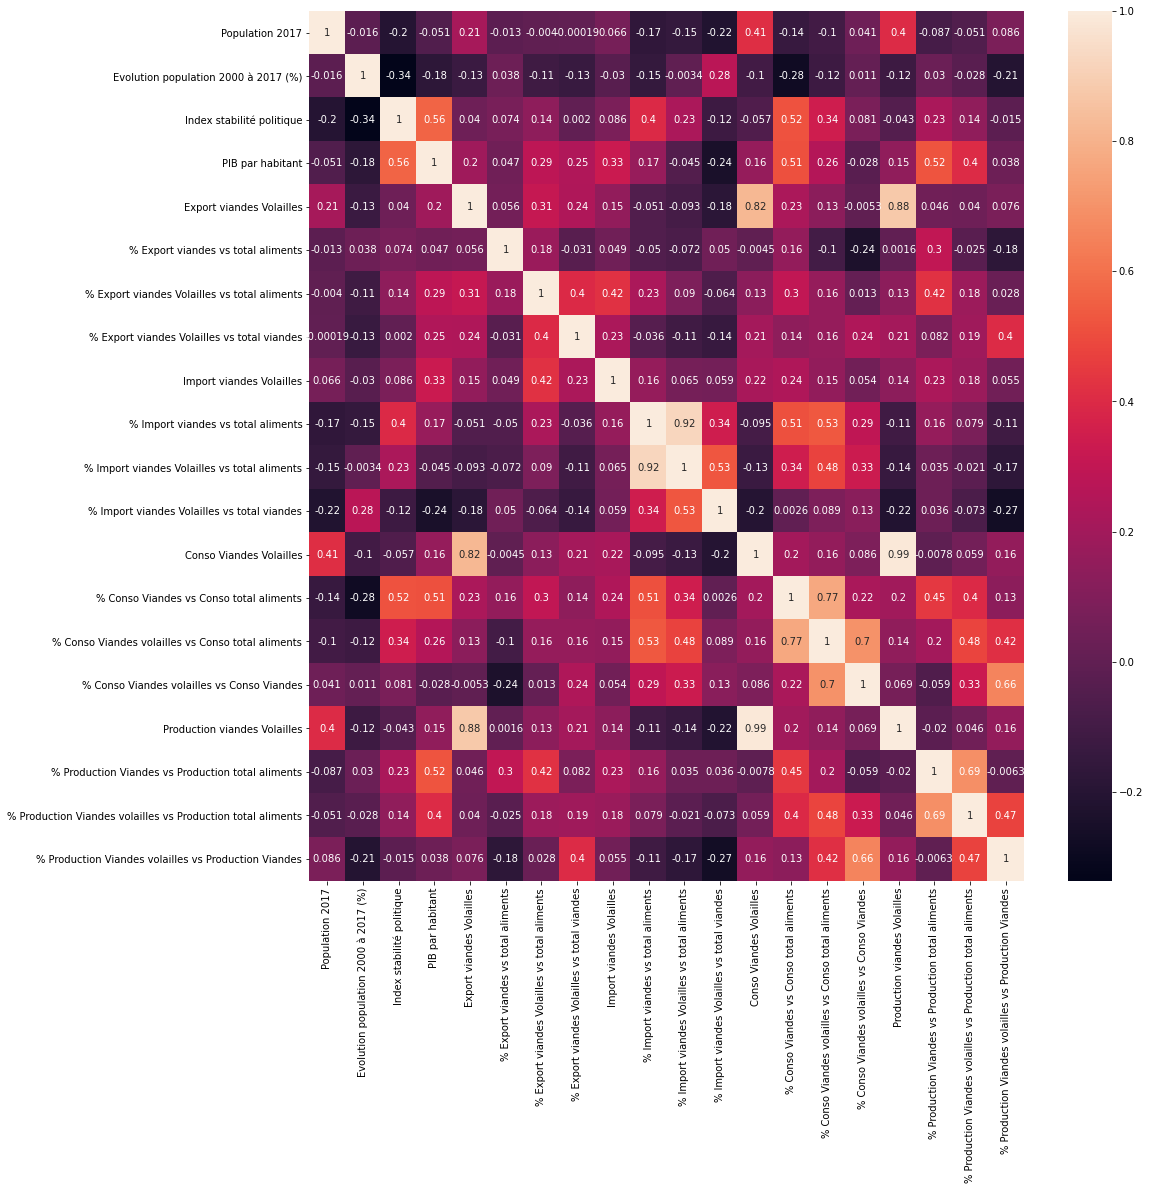

In [88]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(16, 16))
sns.heatmap(corr_df, annot=True)
plt.show()

## Classification ascendante hiérarchique

In [89]:
# Centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(df)
df_scaled = std_scale.transform(df)

In [90]:
#On crée un dataframe de nos données centrées réduites car on s'en servira pour afficher la heatmap des centroïds
df_s = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)
df_s.head()

,Population 2017,Evolution population 2000 à 2017 (%),Index stabilité politique,PIB par habitant,Export viandes Volailles,% Export viandes vs total aliments,% Export viandes Volailles vs total aliments,% Export viandes Volailles vs total viandes,Import viandes Volailles,% Import viandes vs total aliments,% Import viandes Volailles vs total aliments,% Import viandes Volailles vs total viandes,Conso Viandes Volailles,% Conso Viandes vs Conso total aliments,% Conso Viandes volailles vs Conso total aliments,% Conso Viandes volailles vs Conso Viandes,Production viandes Volailles,% Production Viandes vs Production total aliments,% Production Viandes volailles vs Production total aliments,% Production Viandes volailles vs Production Viandes
Zone,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.003511,1.539643,-3.187413,-0.878720,-0.228063,-0.281140,-0.307715,-0.720433,-0.313559,-0.741724,-0.487341,1.156164,-0.298013,-1.145077,-1.005548,-1.098273,-0.283177,-0.270371,-0.517539,-0.985427
Afrique du Sud,0.185291,-0.105840,-0.282201,-0.367720,-0.093993,-0.144661,0.055441,0.770854,2.269985,0.437625,0.879186,1.373802,0.843712,1.053809,1.382094,0.886135,0.483715,0.095999,0.469444,0.722917
Albanie,-0.289707,-1.295028,0.478688,-0.364373,-0.228063,-0.281140,-0.307715,-0.720433,-0.265617,0.318842,0.501096,0.902355,-0.302626,-0.793465,-0.658762,-0.295309,-0.290195,-0.342209,-0.486135,-0.793267
Algérie,0.048207,0.119215,-1.020032,-0.414000,-0.228063,-0.281140,-0.307715,-0.720433,-0.457385,-0.849902,-0.657482,-1.245448,-0.177498,-1.184437,-0.854079,-0.260686,-0.167605,-0.234453,-0.163123,0.114022
Allemagne,0.410380,-0.973078,0.720789,1.564890,1.146685,0.342620,0.393112,-0.096524,4.017207,-0.054478,-0.317200,-0.404382,0.598068,0.662837,-0.351837,-0.882473,0.412126,0.162448,-0.221444,-0.644852


In [91]:
df_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [92]:
df_scaled.mean(axis=0)

array([ 0.00000000e+00, -1.32399268e-16, -5.51663615e-18,  9.92994506e-17,
        1.03436928e-18, -3.03414988e-17,  7.72329061e-17,  6.34413157e-17,
       -1.10332723e-17,  5.51663615e-18,  2.20665446e-17,  5.93038386e-17,
       -6.89579518e-18,  1.10332723e-16, -3.30998169e-17,  2.64798535e-16,
       -4.13747711e-18, -1.21365995e-16, -5.51663615e-17, -1.10332723e-16])

In [93]:
Z = linkage(df_scaled,method='ward',metric='euclidean')

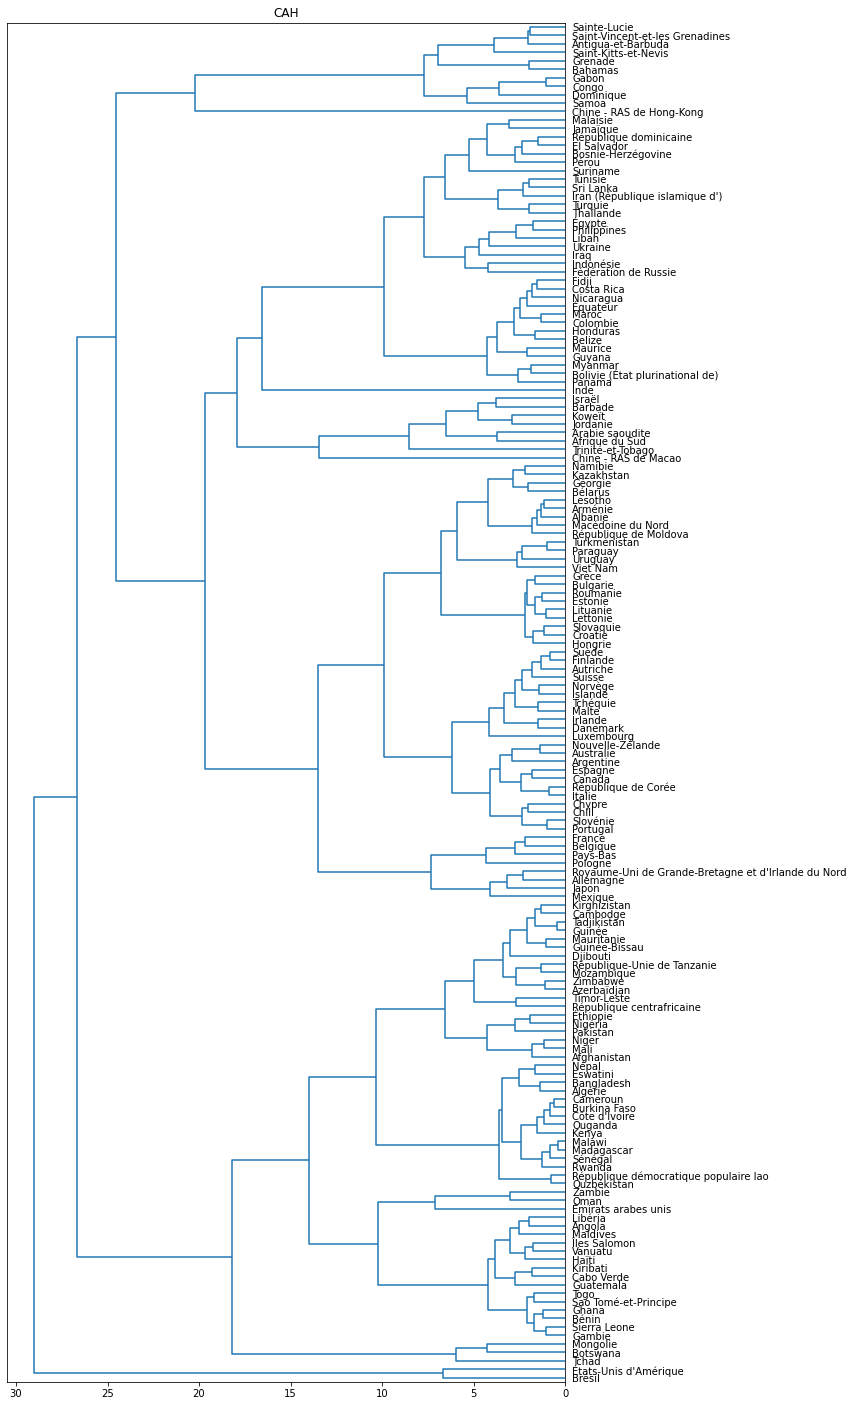

In [94]:
plt.figure(figsize=(10,25))
plt.title("CAH")
dendrogram(Z,labels=df.index,orientation='left',color_threshold=0,leaf_font_size=10)
plt.show()

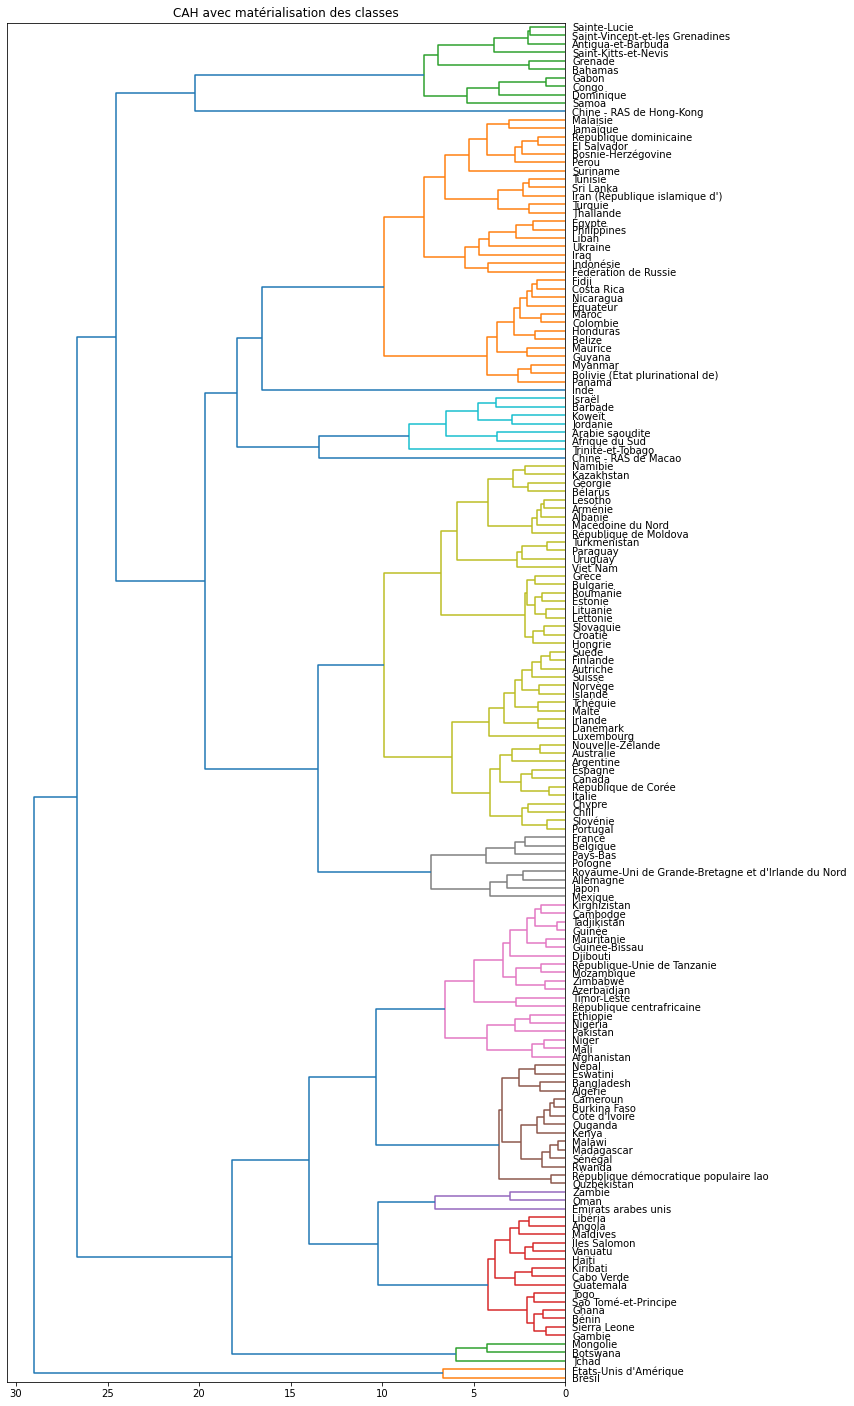

In [95]:
plt.figure(figsize=(10,25))
plt.title('CAH avec matérialisation des classes')
dendrogram(Z,labels=df.index,orientation='left',color_threshold=10,leaf_font_size=10)
plt.show()

In [96]:
groupes_cah = fcluster(Z,t=10,criterion='distance')
print(np.unique(groupes_cah).size, "groupes constitués")

14 groupes constitués


In [97]:
df["cah"] = groupes_cah
df.head()

,Population 2017,Evolution population 2000 à 2017 (%),Index stabilité politique,PIB par habitant,Export viandes Volailles,% Export viandes vs total aliments,% Export viandes Volailles vs total aliments,% Export viandes Volailles vs total viandes,Import viandes Volailles,% Import viandes vs total aliments,...,% Import viandes Volailles vs total viandes,Conso Viandes Volailles,% Conso Viandes vs Conso total aliments,% Conso Viandes volailles vs Conso total aliments,% Conso Viandes volailles vs Conso Viandes,Production viandes Volailles,% Production Viandes vs Production total aliments,% Production Viandes volailles vs Production total aliments,% Production Viandes volailles vs Production Viandes,cah
Zone,,,,,,,,,,,,,,,,,,,,,
Afghanistan,36296113.0,74.67,-2.80,2058.4,0.0,0.00,0.00,0.00,29.0,0.77,...,82.86,55.0,2.41,0.42,17.63,28.0,2.53,0.24,9.52,6
Afrique du Sud,57009756.0,26.78,-0.28,12701.3,63.0,1.35,0.57,42.57,514.0,6.33,...,90.02,2035.0,10.79,6.41,59.47,1667.0,4.57,2.44,53.26,9
Albanie,2884169.0,-7.83,0.38,12771.0,0.0,0.00,0.00,0.00,38.0,5.77,...,74.51,47.0,3.75,1.29,34.56,13.0,2.13,0.31,14.44,8
Algérie,41389189.0,33.33,-0.92,11737.4,0.0,0.00,0.00,0.00,2.0,0.26,...,3.85,264.0,2.26,0.80,35.29,275.0,2.73,1.03,37.67,5
Allemagne,82658409.0,1.54,0.59,52952.9,646.0,6.17,1.10,17.81,842.0,4.01,...,31.52,1609.0,9.30,2.06,22.18,1514.0,4.94,0.90,18.24,7


In [98]:
df[df.index.get_level_values('Zone') == "États-Unis d'Amérique"]

,Population 2017,Evolution population 2000 à 2017 (%),Index stabilité politique,PIB par habitant,Export viandes Volailles,% Export viandes vs total aliments,% Export viandes Volailles vs total aliments,% Export viandes Volailles vs total viandes,Import viandes Volailles,% Import viandes vs total aliments,...,% Import viandes Volailles vs total viandes,Conso Viandes Volailles,% Conso Viandes vs Conso total aliments,% Conso Viandes volailles vs Conso total aliments,% Conso Viandes volailles vs Conso Viandes,Production viandes Volailles,% Production Viandes vs Production total aliments,% Production Viandes volailles vs Production total aliments,% Production Viandes volailles vs Production Viandes,cah
Zone,,,,,,,,,,,,,,,,,,,,,
États-Unis d'Amérique,325084756.0,15.4,0.34,60109.7,3692.0,3.66,1.78,48.68,123.0,2.77,...,5.26,18100.0,12.53,5.62,44.86,21914.0,4.7,2.25,47.86,1


## Algorithme du K-means

In [99]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 14):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

C:\Users\perso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


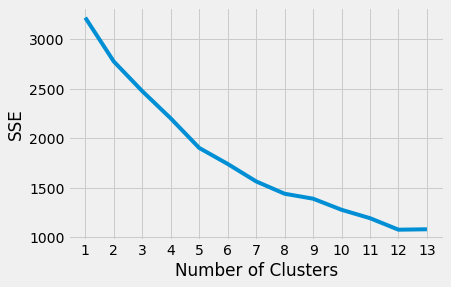

In [100]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 14), sse)
plt.xticks(range(1, 14))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [101]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 15):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    score = metrics.silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

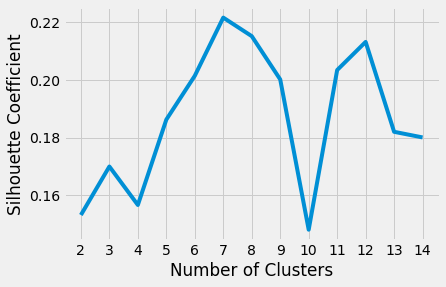

In [102]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [103]:
cls = cluster.KMeans(init='random', n_clusters=14, n_init=10, max_iter =300, random_state = 42)
cls.fit(df_scaled)

KMeans(init='random', n_clusters=14, random_state=42)

In [104]:
#On ajoute la variable au dataframe initial
df['Kmeans'] = cls.labels_

In [105]:
for i in range(0,14):
    print("Groupe {}:".format(i))
    print(", ".join(df[df["Kmeans"]==i].index.get_level_values('Zone').sort_values()))

Groupe 0:
Bosnie-Herzégovine, El Salvador, Indonésie, Iran (République islamique d'), Liban, Sri Lanka, Thaïlande, Tunisie, Turquie, Égypte
Groupe 1:
Angola, Bénin, Cabo Verde, Gambie, Ghana, Guatemala, Haïti, Iraq, Kiribati, Libéria, Maldives, Oman, Sao Tomé-et-Principe, Sierra Leone, Togo, Vanuatu, Îles Salomon
Groupe 2:
Algérie, Bangladesh, Burkina Faso, Cameroun, Côte d'Ivoire, Kenya, Madagascar, Malawi, Nigéria, Népal, Ouganda, Ouzbékistan, Rwanda, République démocratique populaire lao, République-Unie de Tanzanie, Sénégal
Groupe 3:
Barbade, Belize, Bolivie (État plurinational de), Colombie, Costa Rica, Fidji, Guyana, Honduras, Israël, Jamaïque, Jordanie, Malaisie, Maroc, Maurice, Myanmar, Nicaragua, Panama, Pérou, République dominicaine, Suriname
Groupe 4:
Inde
Groupe 5:
Albanie, Arménie, Géorgie, Kazakhstan, Lesotho, Macédoine du Nord, Namibie, Philippines, République centrafricaine, République de Moldova, Timor-Leste, Ukraine, Zambie
Groupe 6:
Botswana, Mongolie, Tchad
Groupe 7

## Analyse en Composante Principale (ACP)

In [106]:
df

,Population 2017,Evolution population 2000 à 2017 (%),Index stabilité politique,PIB par habitant,Export viandes Volailles,% Export viandes vs total aliments,% Export viandes Volailles vs total aliments,% Export viandes Volailles vs total viandes,Import viandes Volailles,% Import viandes vs total aliments,...,Conso Viandes Volailles,% Conso Viandes vs Conso total aliments,% Conso Viandes volailles vs Conso total aliments,% Conso Viandes volailles vs Conso Viandes,Production viandes Volailles,% Production Viandes vs Production total aliments,% Production Viandes volailles vs Production total aliments,% Production Viandes volailles vs Production Viandes,cah,Kmeans
Zone,,,,,,,,,,,,,,,,,,,,,
Afghanistan,36296113.0,74.67,-2.80,2058.4,0.0,0.00,0.00,0.00,29.0,0.77,...,55.0,2.41,0.42,17.63,28.0,2.53,0.24,9.52,6,11
Afrique du Sud,57009756.0,26.78,-0.28,12701.3,63.0,1.35,0.57,42.57,514.0,6.33,...,2035.0,10.79,6.41,59.47,1667.0,4.57,2.44,53.26,9,8
Albanie,2884169.0,-7.83,0.38,12771.0,0.0,0.00,0.00,0.00,38.0,5.77,...,47.0,3.75,1.29,34.56,13.0,2.13,0.31,14.44,8,5
Algérie,41389189.0,33.33,-0.92,11737.4,0.0,0.00,0.00,0.00,2.0,0.26,...,264.0,2.26,0.80,35.29,275.0,2.73,1.03,37.67,5,2
Allemagne,82658409.0,1.54,0.59,52952.9,646.0,6.17,1.10,17.81,842.0,4.01,...,1609.0,9.30,2.06,22.18,1514.0,4.94,0.90,18.24,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,9487203.0,202.71,0.62,67183.6,94.0,2.40,1.91,79.66,433.0,4.08,...,412.0,9.87,6.92,70.07,48.0,8.87,2.68,30.19,4,9
Équateur,16785361.0,32.36,-0.07,11617.9,0.0,0.00,0.00,0.00,0.0,0.05,...,324.0,8.02,3.42,42.69,340.0,2.54,1.10,43.37,11,12
États-Unis d'Amérique,325084756.0,15.40,0.34,60109.7,3692.0,3.66,1.78,48.68,123.0,2.77,...,18100.0,12.53,5.62,44.86,21914.0,4.70,2.25,47.86,1,7


In [134]:
features = ['Population 2017', "Evolution population 2000 à 2017 (%)", 'Index stabilité politique', 'PIB par habitant',"Conso Viandes Volailles","Import viandes Volailles"]
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['cah']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [136]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [138]:
finalDf = pd.concat([principalDf, df[['cah']]], axis = 1)

In [145]:
finalDf

,principal component 1,principal component 2,cah
0,-3.116545,0.688053,NaN
1,0.563697,1.406390,NaN
2,0.415327,-0.628230,NaN
3,-1.075130,0.084946,NaN
4,3.189656,1.581292,NaN
...,...,...,...
Émirats arabes unis,NaN,NaN,4.0
Équateur,NaN,NaN,11.0
États-Unis d'Amérique,NaN,NaN,1.0
Éthiopie,NaN,NaN,6.0


ValueError: ('Lengths must match to compare', (322,), (3,))

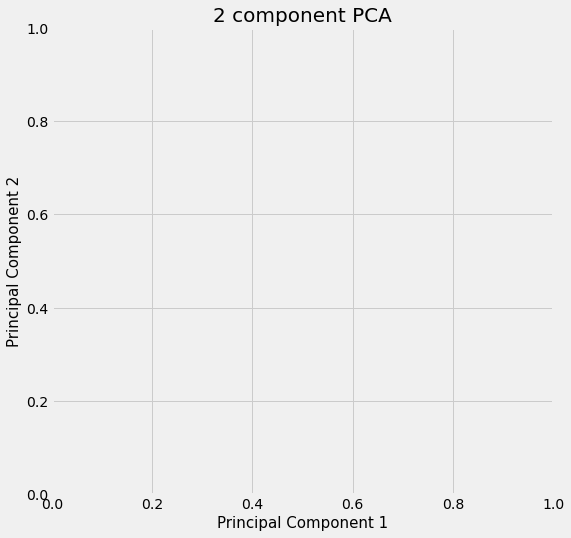

In [144]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
cah = ['1', '2', '3']
colors = ['r', 'g', 'b']
for target, color in zip(cah,colors):
    indicesToKeep = finalDf['cah'] == cah
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(cah)
ax.grid()

In [128]:
pca.fit(scaled_data)

PCA(n_components=2)

In [129]:
x_pca=pca.transform(scaled_data)

In [130]:
scaled_data.shape

(161, 22)

In [131]:
x_pca.shape

(161, 2)

In [132]:
scaled_data

array([[ 0.00351137,  1.5396426 , -3.18741313, ..., -0.9854266 ,
        -0.57600434,  0.87152296],
       [ 0.18529104, -0.10584049, -0.2822006 , ...,  0.72291658,
         0.42836424,  0.23852207],
       [-0.28970658, -1.29502759,  0.4786884 , ..., -0.79326728,
         0.09357471, -0.39447881],
       ...,
       [ 2.53787498, -0.49685318,  0.43257392, ...,  0.51201001,
        -2.24995195,  0.02752178],
       [ 0.61873136,  1.05826407, -1.89620756, ..., -1.26546365,
        -0.57600434,  0.87152296],
       [-0.30943582,  0.83389563,  0.27117322, ..., -1.35724706,
        -1.58037291, -1.23847999]])

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df[''],cmap='plasma')
plt.xlabel('1er composante principale')
plt.ylabel('2eme composante principale')